# Isochrones fitting - 47 Tuc

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib widget

Import the data of the cluster and the isochrone file.

In [2]:
# load and clean data
input_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/hlsp_hugs_hst_wfc3-uvis-acs-wfc_ngc0104_multi_v1_catalog-meth1.txt'
df = pd.read_csv(input_file, header=None, delim_whitespace=True, 
                   usecols=[0, 1, 2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32], 
                   names=['X','Y','F275W','rad_275','F336W','rad_336','F435W','rad_435','F606W','rad_606','F814W','rad_814','prob_member'], skiprows=55)

df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()

# flag the data that are ok (membership probability and radxs)
# set the conditions
conditions = (
    (df['prob_member'] >= 90) & 
    (np.abs(df['rad_275']) < 0.05) &
    (np.abs(df['rad_336']) < 0.05) &
    (np.abs(df['rad_435']) < 0.05) &
    (np.abs(df['rad_606']) < 0.05) &
    (np.abs(df['rad_814']) < 0.05) 
    )   

# assign the flag 
df['flag'] = np.where(conditions, 1, 0)

# select the data with flag 1 
data = df[df['flag'] == 1]

In [3]:
# read the .dat file for the isochrone
iso_basti = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/FEHm075/12000z0054990y255P04O1D1E1.isc_acs', delim_whitespace=True, skiprows=6)

iso_pd = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/isochrone_pd_47tuc_2.dat', delim_whitespace=True, skiprows=13)

# rename the columns F814Wmag and F606Wmag to be more consistent with the other isochrones
iso_pd = iso_pd.rename(columns={'F814Wmag': 'F814W', 'F606Wmag': 'F606W'})  

Plot both the data and the isochrone, verify if the horizontal branch is present in the isochrone. If not, look for another isochrone. The isochrone will be shifted up and on the left with respect to the cluster since is at unit distance. We need to correct for distance modulus in vertical to match the cluster and the reddening to shift it in the horizontal axis. 

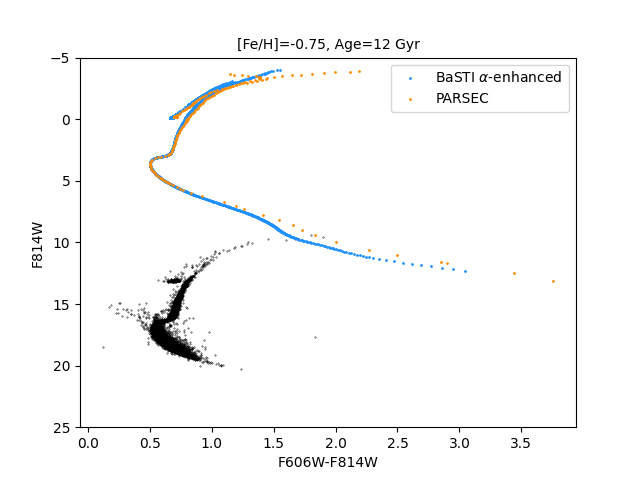

In [4]:
plt.figure()

plt.scatter(iso_basti['F606W']-iso_basti['F814W'], iso_basti['F814W'], s=1, c='dodgerblue', label=r'BaSTI ${\alpha}$-enhanced ', zorder=2)
plt.scatter(iso_pd['F606W']-iso_pd['F814W'], iso_pd['F814W'], s=1, c='darkorange', label='PARSEC', zorder=2)

plt.scatter(data['F606W']-data['F814W'], data['F814W'], s=0.1, c='black', zorder=1)

plt.gca().invert_yaxis()
plt.ylim(25,-5)

plt.xlabel('F606W-F814W')
plt.ylabel('F814W')
plt.title('[Fe/H]=-0.75, Age=12 Gyr', fontsize=10)
plt.legend()
plt.show()

In [5]:
# distance modulus and color excess E(B-V) from Brogaard 2017
distance_modulus = 13.21
color_excess = 0.02

# coefficients for the reddening correction 
R_I = 1.8420        # F814W
R_V = 2.8782        # F606W

iso_basti['F606W'] = iso_basti['F606W'] + distance_modulus + color_excess * R_V
iso_basti['F814W'] = iso_basti['F814W'] + distance_modulus + color_excess * R_I

iso_pd['F606W'] = iso_pd['F606W'] + distance_modulus + color_excess * R_V
iso_pd['F814W'] = iso_pd['F814W'] + distance_modulus + color_excess * R_I

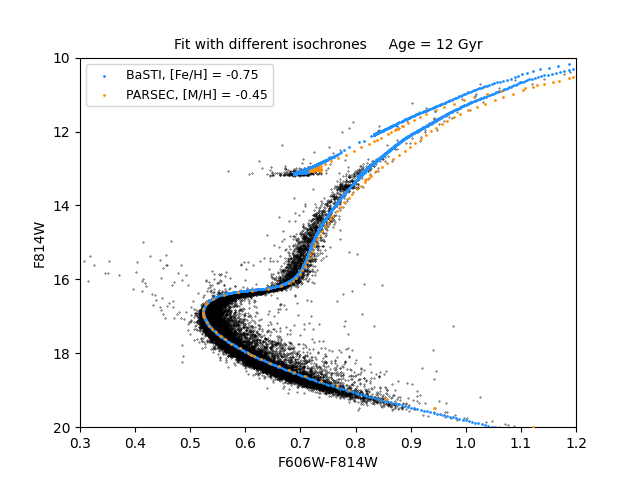

In [6]:
plt.figure()

plt.scatter(iso_basti['F606W']-iso_basti['F814W'], iso_basti['F814W'], s=1, c='dodgerblue', label=r'BaSTI, [Fe/H] = -0.75 ', zorder=2)
plt.scatter(iso_pd['F606W']-iso_pd['F814W'], iso_pd['F814W'], s=1, c='darkorange', label='PARSEC, [M/H] = -0.45', zorder=3)

plt.scatter(data['F606W']-data['F814W'], data['F814W'], s=0.1, c='black', zorder=1)

plt.gca().invert_yaxis()
plt.ylim(20,10)
plt.xlim(0.3,1.2)

plt.xlabel('F606W-F814W')
plt.ylabel('F814W')

plt.title('Fit with different isochrones     Age = 12 Gyr', fontsize=10)
plt.legend(fontsize=9)
plt.show()

In [7]:
import sys
import os

# set the path to the tools folder
module_path = '/Users/giadaaggio/Desktop/Thesis/TOTORO/CODES/tools'
sys.path.append(module_path)

from binaries_utils import BinaryStarUtils
binary = BinaryStarUtils()

colormap = plt.cm.jet

In [8]:
primary_stars = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/primary_stars.csv', delim_whitespace=True)
primary_stars['index'] = primary_stars.index
color_test = colors = binary.color_index(primary_stars, 'index', colormap)

BS_HB_vis = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/BS_HB_vis.csv', delim_whitespace=True, skiprows=2)

color_vis = binary.color_index(BS_HB_vis, 'secondary', colormap)

In [9]:
bound_bin_vis_low = BS_HB_vis[(BS_HB_vis['primary'] == 23) & (BS_HB_vis['secondary'] == 11)]
bound_bin_vis_high = BS_HB_vis[(BS_HB_vis['primary'] == 23) & (BS_HB_vis['secondary'] == 15)]

In [10]:
prim_for_ratio = primary_stars[primary_stars['index'] == 23]
sec_for_ratio_low = primary_stars[primary_stars['index'] == 11]

sec_for_ratio_high = primary_stars[primary_stars['index'] == 15]

In [11]:
# find the mass of the prim_for_ratio and sec_for_ratio_low using the isochrone iso_basti_1
# we need to find at which mass corresponds the magnitude of the two stars, no need to interpolate the isochrone
# we can use the closest value to the magnitude of the star

# find the mass of the primary star
magnitude_prim = prim_for_ratio['F814W'].values[0]

magnitude_sec_low = sec_for_ratio_low['F814W'].values[0]

magnitude_sec_high = sec_for_ratio_high['F814W'].values[0]

In [12]:
# MASSES IN THE BASTI ISOCHRONE

# find the point in iso_basti that is closest to the magnitude of the primary star and more on the right in the plot
idx_prim_basti_alpha = (iso_basti['F814W']-magnitude_prim).abs().idxmin()
mass_prim_basti_alpha = iso_basti['M/Mo(ini)'].iloc[idx_prim_basti_alpha]
print(mass_prim_basti_alpha)

idx_sec_low_basti_alpha = (iso_basti['F814W']-magnitude_sec_low).abs().idxmin()
mass_sec_low_basti_alpha = iso_basti['M/Mo(ini)'].iloc[idx_sec_low_basti_alpha]
print(mass_sec_low_basti_alpha)

idx_sec_high_basti_alpha = (iso_basti['F814W']-magnitude_sec_high).abs().idxmin()
mass_sec_high_basti_alpha = iso_basti['M/Mo(ini)'].iloc[idx_sec_high_basti_alpha]
print(mass_sec_high_basti_alpha)

q_low_basti_alpha = mass_sec_low_basti_alpha/mass_prim_basti_alpha
print('lowest q:', q_low_basti_alpha)

q_high_basti_alpha = mass_sec_high_basti_alpha/mass_prim_basti_alpha
print('highest q:', q_high_basti_alpha)

0.8983632796
0.8915976013
0.8992768533
lowest q: 0.9924688837426521
highest q: 1.001016931257928


In [13]:
# DO THE SAME FOR THE PADOVA ISOCHRONE

# find the point in iso_pd that is closest to the magnitude of the primary star, in case of the same magnitude, take the one on the left
iso_pd_HB = iso_pd[(iso_pd['F606W'] - iso_pd['F814W'] < 0.75)]

idx_prim_pd = (iso_pd_HB['F814W']-magnitude_prim).abs().idxmin()
mass_prim_pd = iso_pd['Mini'].iloc[idx_prim_pd]
print(mass_prim_pd)

idx_sec_low_pd = (iso_pd['F814W']-magnitude_sec_low).abs().idxmin()
mass_sec_low_pd = iso_pd['Mini'].iloc[idx_sec_low_pd]
print(mass_sec_low_pd)

idx_sec_high_pd = (iso_pd['F814W']-magnitude_sec_high).abs().idxmin()
mass_sec_high_pd = iso_pd['Mini'].iloc[idx_sec_high_pd]
print(mass_sec_high_pd)

q_low_pd = mass_sec_low_pd/mass_prim_pd
print('lowest q:', q_low_pd)

q_high_pd = mass_sec_high_pd/mass_prim_pd
print('highest q:', q_high_pd)


0.8978409171
0.8911785483
0.8985081315
lowest q: 0.9925795665210723
highest q: 1.000743132093105


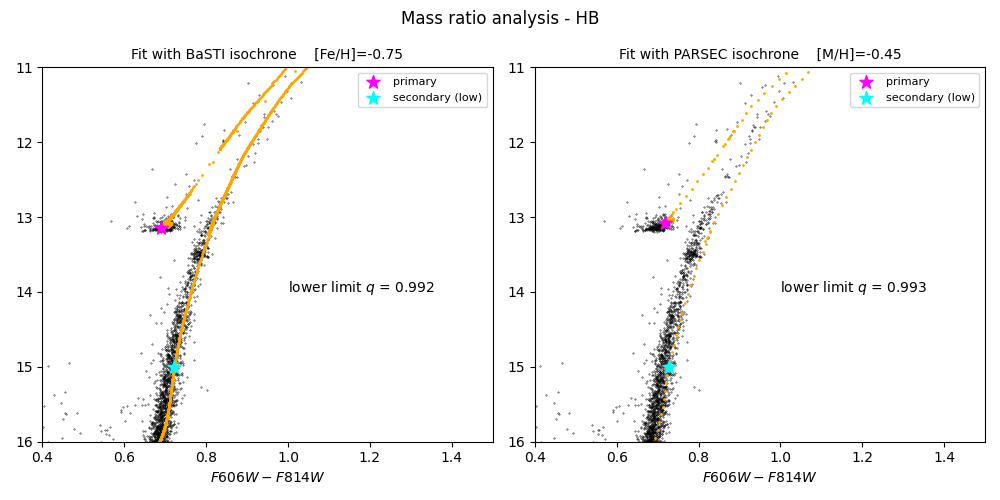

In [14]:
# plot the isochrone with the primary and secondary star
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax2 = axes[0]
ax2.scatter(iso_basti['F606W']-iso_basti['F814W'], iso_basti['F814W'], s=1, c='orange', zorder=2)
ax2.scatter(data['F606W']-data['F814W'], data['F814W'], s=0.1, c='black', zorder=1)
ax2.scatter(iso_basti['F606W'].iloc[idx_prim_basti_alpha]-iso_basti['F814W'].iloc[idx_prim_basti_alpha], iso_basti['F814W'].iloc[idx_prim_basti_alpha], s=100, color='magenta', label='primary', marker='*', zorder=3)
ax2.scatter(iso_basti['F606W'].iloc[idx_sec_low_basti_alpha]-iso_basti['F814W'].iloc[idx_sec_low_basti_alpha], iso_basti['F814W'].iloc[idx_sec_low_basti_alpha], s=100, color='aqua', label='secondary (low)', marker='*', zorder=3)

ax2.invert_yaxis()
ax2.set_ylim(16,11)
ax2.set_xlim(0.4,1.5)

ax2.set_xlabel(r'$F606W-F814W$')
ax2.set_title('Fit with BaSTI isochrone    [Fe/H]=-0.75', fontsize=10)

ax2.text(1., 14, f'lower limit $q$ = {q_low_basti_alpha:.3f}', fontsize=10, color='black')
ax2.legend(fontsize=8)

ax3 = axes[1]
ax3.scatter(iso_pd['F606W']-iso_pd['F814W'], iso_pd['F814W'], s=1, c='orange', zorder=2)
ax3.scatter(data['F606W']-data['F814W'], data['F814W'], s=0.1, c='black', zorder=1)
ax3.scatter(iso_pd['F606W'].iloc[idx_prim_pd]-iso_pd['F814W'].iloc[idx_prim_pd], iso_pd['F814W'].iloc[idx_prim_pd], s=100, color='magenta', label='primary', marker='*', zorder=3)
ax3.scatter(iso_pd['F606W'].iloc[idx_sec_low_pd]-iso_pd['F814W'].iloc[idx_sec_low_pd], iso_pd['F814W'].iloc[idx_sec_low_pd], s=100, color='aqua', label='secondary (low)', marker='*', zorder=3)

ax3.invert_yaxis()
ax3.set_ylim(16,11)
ax3.set_xlim(0.4,1.5)

ax3.set_xlabel(r'$F606W-F814W$')
ax3.set_title('Fit with PARSEC isochrone    [M/H]=-0.45', fontsize=10)

ax3.text(1., 14, f'lower limit $q$ = {q_low_pd:.3f}', fontsize=10, color='black')
ax3.legend(fontsize=8)

plt.suptitle('Mass ratio analysis - HB')

plt.tight_layout()
plt.show()
